# Models (sepsis-pics)


## Common


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from common_eicu import KEY_IDENTITY, KEY_FLAG, CATEGORICAL_COLUMNS_FULL


In [2]:
SEED = 1011
SCORING = ['accuracy', 'roc_auc']
CV_FOLDS = 10
cv = StratifiedGroupKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=SEED,
)


In [3]:
MODEL_RESULT_PATH = './data/model_result.csv'

# index: 'accuracy mean', 'accuracy std', 'AUC mean', 'AUC std'
df_result = pd.read_csv(
    MODEL_RESULT_PATH,
    index_col='index',
)

def update_result(name, *, accuracy_mean, accuracy_std, auc_mean, auc_std):
    df_result[name] = [accuracy_mean, accuracy_std, auc_mean, auc_std]
    df_result.to_csv(MODEL_RESULT_PATH)


In [4]:
def plot_roc_file(title, input_path, auc_mean, auc_std):

    df_roc = pd.read_csv(input_path, sep='\t')
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot()

    ax.set_title(title)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    t = [0, 1]
    ax.plot(t, t, '--', c='lightgray', label='chance level (AUC = 0.5)')

    x = df_roc['FPR']
    y = df_roc['TPR']
    label = fr'ROC (AUC = {auc_mean:.2f} $\pm$ {auc_std:.2f})'
    ax.plot(x, y, 'b-', label=label)

    ax.legend(loc='lower right')


In [5]:
def test_sklearn(name, model, encode=False):
    '''
    Test the given model using sklearn's
    cross validation, print the result
    and pass it to `update_result`.

    Parameters
    ----------
    name : str
        Model name.
    model : scikit-learn compact model
        The model to test.
    encode : False, 'ordinal' or 'dummy', default=False
        Category encoding option.
        False - No encoding.
        'ordinal' - Use ordinal encoder.
        'dummy' - Use dummy encoder.
    '''

    if encode == 'dummy':
        X = X_dummy
    elif encode == 'ordinal':
        X = X_ordinal
    else:
        X = X_raw

    scores = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=SCORING,
        groups=groups,
    )

    scores_accuracy = scores['test_accuracy']
    accuracy_mean = scores_accuracy.mean()
    accuracy_std = scores_accuracy.std()
    scores_auc = scores['test_roc_auc']
    auc_mean = scores_auc.mean()
    auc_std = scores_auc.std()
    update_result(
        name,
        accuracy_mean=accuracy_mean,
        accuracy_std=accuracy_std,
        auc_mean=auc_mean,
        auc_std=auc_std,
    )

    print(f'>>> CV Result ({name})')
    print(f'accuracy_mean: {accuracy_mean:.4f}')
    print(f'accuracy_std:  {accuracy_std:.4f}')
    print(f'auc_mean:      {auc_mean:.4f}')
    print(f'auc_std:       {auc_std:.4f}')


## Prepare Data


In [6]:
df_data = pd.read_csv('./data/data_eicu_full.csv.gz')

# clamp infinite values
df_data.replace(np.inf, 9999, inplace=True)

# set categorical columns
for column_name in CATEGORICAL_COLUMNS_FULL:
    df_data[column_name] = df_data[column_name].astype('category')


In [7]:
X_raw = df_data.drop(columns=[KEY_IDENTITY, KEY_FLAG])
X_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100133 entries, 0 to 100132
Data columns (total 59 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   gender              100133 non-null  category
 1   age                 100133 non-null  float64 
 2   ethnicity           100133 non-null  category
 3   offset              100133 non-null  int64   
 4   vasopressor         100133 non-null  category
 5   heparin             100133 non-null  category
 6   urine               100133 non-null  float64 
 7   PEEP                100133 non-null  float64 
 8   creatinine          100133 non-null  float64 
 9   platelet            100133 non-null  float64 
 10  INR                 100133 non-null  float64 
 11  PT                  100133 non-null  float64 
 12  PTT                 100133 non-null  float64 
 13  lactate             100133 non-null  float64 
 14  RDW                 100133 non-null  float64 
 15  total bilirubin  

In [8]:
ordinal_encoder = OrdinalEncoder(dtype=int)
X_ordinal = X_raw.copy()
X_ordinal[CATEGORICAL_COLUMNS_FULL] = \
    ordinal_encoder.fit_transform(X_ordinal[CATEGORICAL_COLUMNS_FULL])
X_ordinal.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100133 entries, 0 to 100132
Data columns (total 59 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   gender              100133 non-null  int32  
 1   age                 100133 non-null  float64
 2   ethnicity           100133 non-null  int32  
 3   offset              100133 non-null  int64  
 4   vasopressor         100133 non-null  int32  
 5   heparin             100133 non-null  int32  
 6   urine               100133 non-null  float64
 7   PEEP                100133 non-null  float64
 8   creatinine          100133 non-null  float64
 9   platelet            100133 non-null  float64
 10  INR                 100133 non-null  float64
 11  PT                  100133 non-null  float64
 12  PTT                 100133 non-null  float64
 13  lactate             100133 non-null  float64
 14  RDW                 100133 non-null  float64
 15  total bilirubin     100133 non-nul

In [10]:
X_dummy = pd.get_dummies(X_raw)
X_dummy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100133 entries, 0 to 100132
Data columns (total 68 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         100133 non-null  float64
 1   offset                      100133 non-null  int64  
 2   urine                       100133 non-null  float64
 3   PEEP                        100133 non-null  float64
 4   creatinine                  100133 non-null  float64
 5   platelet                    100133 non-null  float64
 6   INR                         100133 non-null  float64
 7   PT                          100133 non-null  float64
 8   PTT                         100133 non-null  float64
 9   lactate                     100133 non-null  float64
 10  RDW                         100133 non-null  float64
 11  total bilirubin             100133 non-null  float64
 12  direct bilirubin            100133 non-null  float64
 13  bicarbonate   

In [11]:
y = df_data[KEY_FLAG].ravel()
y


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [12]:
groups = df_data[KEY_IDENTITY].ravel()
groups


array([ 141288,  141288,  141288, ..., 3353251, 3353251, 3353251],
      dtype=int64)

## CatBoost


In [18]:
%%time
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    cat_features=CATEGORICAL_COLUMNS_FULL,
    task_type='GPU',
    devices='0',
    random_state=SEED,
    verbose=False,
)

test_sklearn(
    'CatBoost',
    catboost_model,
)


>>> CV Result (CatBoost)
accuracy_mean: 0.9957
accuracy_std:  0.0007
auc_mean:      0.9957
auc_std:       0.0021
CPU times: total: 5min 54s
Wall time: 4min 28s


## Light Gradient Boosting


In [28]:
%%time
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    # Categorical features will be automatically detected.
    random_state=SEED,
)

test_sklearn(
    'LightGB',
    lgb_model,
)


>>> CV Result (LightGB)
accuracy_mean: 0.9954
accuracy_std:  0.0009
auc_mean:      0.9960
auc_std:       0.0016
CPU times: total: 1min 37s
Wall time: 18.8 s


## Extreme Gradient Boosting


In [61]:
%%time
from xgboost import XGBClassifier

xgboost_model = XGBClassifier(
    enable_categorical=True,
    tree_method='approx',  # TODO: gpu_hist
    # booster='gblinear',
    # updater='coord_descent',
    # feature_selector='greedy',
    random_state=SEED,
)

test_sklearn(
    'XGBoost',
    xgboost_model,
    # encode='ordinal',
)


>>> CV Result (XGBoost)
accuracy_mean: 0.9952
accuracy_std:  0.0008
auc_mean:      0.9953
auc_std:       0.0018
CPU times: total: 13min 48s
Wall time: 1min 25s


## Gradient Boosting


In [18]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_model = GradientBoostingClassifier(
    random_state=SEED,
)

test_sklearn(
    'GradientBoosting',
    gradient_boosting_model,
)


>>> CV Result (GradientBoosting)
Scores: [0.98302486 0.98230672 0.98166726]
  Mean: 0.9823
   Std: 0.0006


## Extra Trees


In [19]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_model = ExtraTreesClassifier(
    class_weight='balanced',
    random_state=SEED,
)

test_sklearn(
    'ExtraTrees',
    extra_trees_model,
)


>>> CV Result (ExtraTrees)
Scores: [0.98888585 0.99197778 0.98758717]
  Mean: 0.9895
   Std: 0.0018


## Ridge Classifier


In [20]:
%%time
from sklearn.linear_model import RidgeClassifier

ridge_model = RidgeClassifier(
    # class_weight='balanced',  # worse...
    random_state=SEED,
)

test_sklearn(
    'Ridge',
    ridge_model,
)


>>> CV Result (Ridge)
Scores: [0.96213859 0.94504045 0.95426488]
  Mean: 0.9538
   Std: 0.0070


## Logistic Regression


In [21]:
%%time
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(
    solver='newton-cholesky',
    # class_weight='balanced',  # worse...
    random_state=SEED,
)

test_sklearn(
    'Logistic',
    logistic_model,
)


>>> CV Result (Logistic)
Scores: [0.96343016 0.94545958 0.95443583]
  Mean: 0.9544
   Std: 0.0073


## K-Nearest Neighbors


In [22]:
%%time
from sklearn.neighbors import KNeighborsClassifier

neighbors_model = KNeighborsClassifier()

test_sklearn(
    'KNeighbors',
    neighbors_model,
)


>>> CV Result (KNeighbors)
Scores: [0.86439013 0.85513573 0.85173826]
  Mean: 0.8571
   Std: 0.0053


## AdaBoost


In [23]:
%%time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost_model = AdaBoostClassifier(
    n_estimators=68,
    random_state=SEED,
)

test_sklearn(
    'AdaBoost',
    adaboost_model,
)


>>> CV Result (AdaBoost)
Scores: [0.98006773 0.98011872 0.97773297]
  Mean: 0.9793
   Std: 0.0011


## Linear Discriminant Analysis


In [24]:
%%time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()

test_sklearn(
    'LDA',
    lda_model,
)


>>> CV Result (LDA)
Scores: [0.96213859 0.94504051 0.95426486]
  Mean: 0.9538
   Std: 0.0070


## MLP


In [25]:
%%time
from sklearn.neural_network import MLPClassifier

mlp_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=1000,
        random_state=SEED,
    ),
)

test_sklearn(
    'MLP',
    mlp_model,
)


>>> CV Result (MLP)
Scores: [0.98022958 0.97303329 0.97407422]
  Mean: 0.9758
   Std: 0.0032


## Decision Tree


In [26]:
%%time
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=SEED,
)

test_sklearn(
    'DecisionTree',
    decision_tree_model,
)


>>> CV Result (DecisionTree)
Scores: [0.86135349 0.85845094 0.84053631]
  Mean: 0.8534
   Std: 0.0092


## SVM (With RBF Kernel)


In [27]:
%%time
from sklearn.svm import SVC

svm_model = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf',  # default
        random_state=SEED,
    ),
)

test_sklearn(
    'SVM',
    svm_model,
)


>>> CV Result (SVM)
Scores: [0.9721738  0.96024045 0.9611242 ]
  Mean: 0.9645
   Std: 0.0054


## Naive Bayes


In [28]:
%%time
from sklearn.naive_bayes import ComplementNB

# TODO: transform data for this
nb_model = ComplementNB()

test_sklearn(
    'NaiveBayes',
    nb_model,
)


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Program Files\Python39\lib\site-packages\sklearn\naive_bayes.py", line 774, in fit
    self._count(X, Y)
  File "d:\Program Files\Python39\lib\site-packages\sklearn\naive_bayes.py", line 1042, in _count
    check_non_negative(X, "ComplementNB (input X)")
  File "d:\Program Files\Python39\lib\site-packages\sklearn\utils\validation.py", line 1408, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to ComplementNB (input X)


## Summary


In [ ]:
df_summary = df_result.T.sort_values(
    by=['accuracy mean', 'AUC mean'],
    ascending=False,
)

df_summary.style.format('{:.4f}')


,AUC mean,AUC std
AdaBoost,0.6664,0.1590
XGBoost,0.6498,0.0649
Logistic,0.6316,0.0282
CatBoost,0.6288,0.0254
Ridge,0.6285,0.0486
LDA,0.6282,0.0488
NaiveBayes,0.5370,0.0647
GradientBoosting,0.5268,0.0852
ExtraTrees,0.5208,0.0599
LightGB,0.5205,0.0358


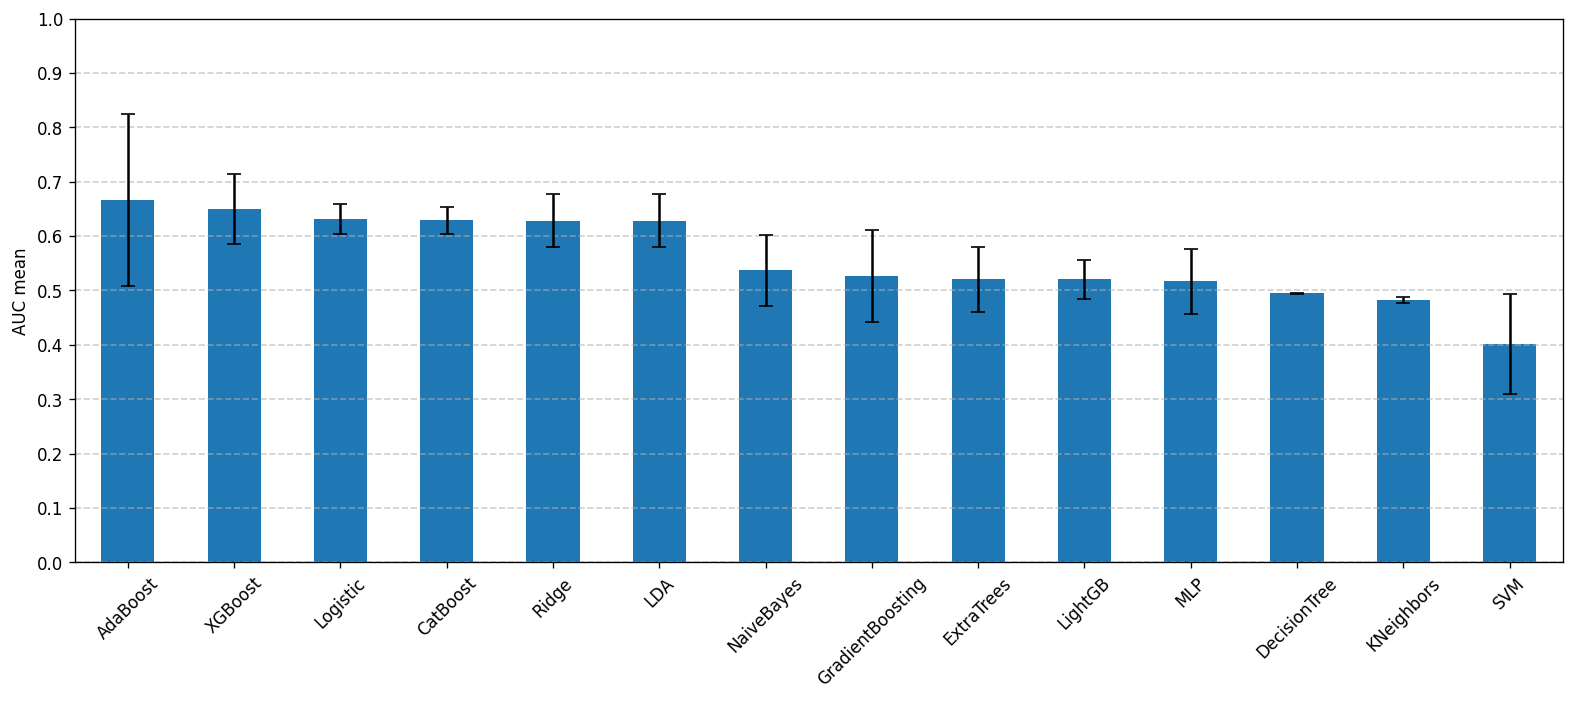

In [ ]:
fig_summary = plt.figure(figsize=(16, 6), dpi=120)
ax_summary = fig_summary.add_subplot()

df_summary['AUC mean'].plot.bar(
    yerr=df_summary['AUC std'],
    ax=ax_summary,
    capsize=4,
    ylim=[0, 1],
    yticks=np.linspace(0, 1, 11),
)

ax_summary.set_ylabel('AUC mean')
ax_summary.grid(axis='y', ls='--', lw=1, alpha=0.6)

# adjust x labels
for label in ax_summary.get_xticklabels():
    label.set_rotation(45)
